# Load Libraries

In [119]:
# numpy and pandas
import numpy as np
import pandas as pd
import math

# Generic
import os
import matplotlib.pyplot as plt

# Images
from PIL import Image
from skimage.transform import resize
import talos as ta

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix

# Tensorflow
import tensorflow as tf

# Keras
from keras.layers import Input, Dense, Dropout
from keras.utils import print_summary
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# Load Classes and Functions

In [87]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [88]:
# chexNet weights
# https://github.com/brucechou1983/CheXNet-Keras
chexnet_weights = 'chexnet/best_weights.h5'

def chexnet_preprocess_input(value):
    return preprocess_input(value)


def get_chexnet_model():
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    # add a logistic layer -- let's say we have 14 classes
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )

    # load chexnet weights
    model.load_weights(chexnet_weights)

    # return model
    return base_model, model

In [89]:
### funciones

def get_class_weight(csv_file_path, target_class, learning_rate):
    df = pd.read_csv(csv_file_path, sep=';')
    total_counts = df.shape[0]
    class_weight = []

    ratio_pos = df.loc[(df[target_class] == 'Y')].shape[0] / total_counts
    ratio_neg = df.loc[(df[target_class] == 'N')].shape[0] / total_counts
    class_weight = np.array((ratio_pos, ratio_neg))
        
    return class_weight


#def auc(y_true, y_pred):
#    auc = tf.metrics.auc(y_true, y_pred)[1]
#    K.get_session().run(tf.local_variables_initializer())
#    return auc


def auc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
    return value

def get_model(learning_rate):
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()
    # print a model summary
    # print_summary(base_model)

    x = base_model.output
    # Dropout layer
    #x = Dropout(0.2)(x)
    # one more layer (relu)
    x = Dense(512, activation='relu')(x)
    # Dropout layer
    #x = Dropout(0.2)(x)
    #x = Dense(256, activation='relu')(x)
    # Dropout layer
    #x = Dropout(0.2)(x)
    # add a logistic layer -- let's say we have 6 classes
    predictions = Dense(
        1,
        activation='sigmoid')(x)

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=predictions,
    )

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # initiate an Adam optimizer
    opt = Adam(
        lr=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        decay=0.0,
        amsgrad=False
    )
    
    #K.clear_session()
    # Let's train the model using Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[auc])
    #K.clear_session()
    
    return base_model, model



In [90]:
def get_model_talos(X_train, y_train, X_val, y_val, params):
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()
    # print a model summary
    # print_summary(base_model)

    x = base_model.output
    # Dropout layer
    #x = Dropout(0.2)(x)
    # one more layer (relu)
    x = Dense(params['first_neuron'], activation='relu')(x)
    # Dropout layer
    #x = Dropout(0.2)(x)
    #x = Dense(256, activation='relu')(x)
    # Dropout layer
    #x = Dropout(0.2)(x)
    # add a logistic layer -- let's say we have 6 classes
    predictions = Dense(
        1,
        activation='sigmoid')(x)

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=predictions,
    )

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # initiate an Adam optimizer
    opt = Adam(
        lr=0.005,
        beta_1=0.9,
        beta_2=0.999,
        decay=0.00001,
        amsgrad=False
    )

    # Let's train the model using Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[auc]
        #metrics=['accuracy']
        )
    
    
    # This callback writes logs for TensorBoard
    tensorboard = TensorBoard(
        log_dir='./Graph', 
        histogram_freq=0,  
        write_graph=True
    )

    my_callbacks = EarlyStopping(monitor='val_auc', patience=300, verbose=1, mode='max')

    callbacks_list = [tensorboard, my_callbacks]


    
    batch_size = params['batch_size']
    out = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=datagen.flow(X_val, y_val),
                     steps_per_epoch=len(X_train) / batch_size, 
                     epochs=params['epochs'],
                     class_weight=class_weight_train,
                     callbacks = callbacks_list,       
                     verbose=0)


    return out, model



# Global Parameters

In [122]:
perc_split = [0.8, 0.2]
input_shape = (224, 224, 3)
batch_size = 16
epochs = 10000
np.random.seed(23)



# Load Data

## Read data

In [92]:
case_features = pd.read_csv(os.path.join('../data/clean_data.csv'), sep=';');
new_case_features = pd.read_csv(os.path.join('../data/new_clean_data.csv'), sep=';');

## Split data

In [93]:
#target_class = 'survival'

### Train and val
# Selección del patrón de datos X y del target y
#y = case_features[target_class]
#del case_features[target_class]
#X = case_features
#Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=1)

### Test
#ytest = new_case_features[target_class]
#del new_case_features[target_class]
#Xtest = new_case_features

In [94]:
target_class = 'survival'

### Train and val
# Split patient ids
positive = case_features[case_features.survival.values == 'Y']
patient_ids = positive.patientid.unique()
train_ids = np.random.choice(patient_ids, size = math.floor(perc_split[0]*len(patient_ids)), replace = False)
test_ids = patient_ids[~np.isin(patient_ids, train_ids)];

negative = case_features[case_features.survival.values == 'N']
patient_ids = negative.patientid.unique()
train_ids = np.append(train_ids, np.random.choice(patient_ids, size = math.floor(perc_split[0]*len(patient_ids)), replace = False))
test_ids = np.append(test_ids, patient_ids[~np.isin(patient_ids, train_ids)]);

# Split dataset based on patient ids
case_features_train = case_features[case_features.patientid.isin(train_ids)]
case_features_val = case_features[case_features.patientid.isin(test_ids)]

# Selección del patrón de datos X y del target y
ytrain = case_features_train[target_class]
del case_features_train[target_class]
Xtrain = case_features_train

yval = case_features_val[target_class]
del case_features_val[target_class]
Xval = case_features_val


### Test
ytest = new_case_features[target_class]
del new_case_features[target_class]
Xtest = new_case_features

## Read images

### Train

In [95]:
X_train = []
for i in range(Xtrain.shape[0]):
    image_path = os.path.join('../data/', 'images', Xtrain.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_train.append(imagen)

X_train = np.stack(X_train, axis = 0)
print(X_train.shape)

(62, 224, 224, 3)


### Validation

In [96]:
X_val = []
for i in range(Xval.shape[0]):
    image_path = os.path.join('../data/', 'images', Xval.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_val.append(imagen)

X_val = np.stack(X_val, axis = 0)
print(X_val.shape)

(24, 224, 224, 3)


### Test

In [97]:
X_test = []
for i in range(Xtest.shape[0]):
    image_path = os.path.join('../data/', 'new_images', Xtest.iloc[i].filename + '.jpeg')
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_test.append(imagen)

X_test = np.stack(X_test, axis = 0)
print(X_test.shape)

(12, 224, 224, 3)


## Set target

### Train

In [140]:
ytrain[ytrain=='Y'] = 0
ytrain[ytrain=='N'] = 1
y_train = np.array(ytrain, dtype = np.int64)
y_train.shape

(62,)

### Validation

In [141]:
yval[yval=='Y'] = 0
yval[yval=='N'] = 1
y_val = np.array(yval, dtype = np.int64)
y_val.shape

(24,)

### Test

In [142]:
ytest[ytest=='Y'] = 0
ytest[ytest=='N'] = 1
y_test = np.array(ytest, dtype = np.int64)
y_test.shape

(12,)

## Set class weights

### Train

In [101]:
ratio_pos = np.count_nonzero(y_train == 0) / len(y_train)
ratio_neg = np.count_nonzero(y_train == 1) / len(y_train)
class_weight_train = np.array((ratio_pos, ratio_neg))
print(class_weight_train)


[0.83870968 0.16129032]


### Validation

In [102]:
ratio_pos = np.count_nonzero(y_val == 0) / len(y_val)
ratio_neg = np.count_nonzero(y_val == 1) / len(y_val)
class_weight_val = np.array((ratio_pos, ratio_neg))
print(class_weight_val)


[0.875 0.125]


### Test

In [103]:
ratio_pos = np.count_nonzero(y_test == 0) / len(y_test)
ratio_neg = np.count_nonzero(y_test == 1) / len(y_test)
class_weight_test = np.array((ratio_pos, ratio_neg))
print(class_weight_test)

[0.41666667 0.58333333]


# Data Augmentation

In [104]:
datagen = ImageDataGenerator(featurewise_center=True, 
                             featurewise_std_normalization=True, 
                             rotation_range=90)
datagen.fit(X_train)

In [82]:
#batch = datagen.flow(X_train, y_train, batch_size=100)
#Xtr,Ytr = batch[0]
#Xtr2 = np.squeeze(Xtr[0,:,:,:])
#plt.imshow(Xtr2, cmap='gray')

# Model Definition

## Callbacks

### Checkpoints

In [105]:
save_dir = os.path.join(
    os.getcwd(),
    '../saved_models'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# This callback saves the weights of the model after each epoch
checkpoint = ModelCheckpoint(
    '../saved_models/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

# This callback writes logs for TensorBoard
tensorboard_augmented = TensorBoard(
    log_dir='./Graph_augmented', 
    histogram_freq=0,  
    write_graph=True
)

my_callbacks = EarlyStopping(monitor='val_auc', patience=200, verbose=1, mode='max')
my_callbacks_augmented = EarlyStopping(monitor='val_auc', patience=100, verbose=1, mode='max')


callbacks_list = [tensorboard, my_callbacks]
callbacks_list_augmented = [tensorboard_augmented, my_callbacks_augmented]

## Define CNN structure

# Hyperparameters tuning 

### Augmented dataset

In [ ]:

epochs = [2000, 10000]
batch_size = [10,15]
learning_rate = [0.0001, 0.001, 0.005]

epochs = [10000]
batch_size = [2**4, 2**5, 2**6]
learning_rate = [0.0001, 0.001, 0.01]
previous_val_auc = 0
df = pd.DataFrame()

for e in epochs:
    for b in batch_size:
        for l in learning_rate:
            print("Numero de épocas", e,", batch size", b,  ", learning rate", l)

            # Augmented
            base_model2, model2 = get_model(l)
            ###### ENTRENAMIENTO
            out = model2.fit_generator(datagen.flow(X_train, y_train, batch_size=b),
                                             validation_data=datagen.flow(X_val, y_val),
                                             steps_per_epoch=len(X_train) / b, 
                                             epochs=e,
                                             class_weight=class_weight_train,
                                             callbacks = callbacks_list_augmented,       
                                             verbose=0)

            train_loss = out.history['loss'][-1]
            val_loss = out.history['val_loss'][-1]
            train_auc = out.history['auc'][-1]
            val_auc = out.history['val_auc'][-1]
            stopped_epoch = my_callbacks.stopped_epoch
            model = out.model
            
            res = pd.DataFrame([e, l, b, stopped_epoch, train_loss, val_loss, train_auc, val_auc])
            df = pd.concat([df, res], axis=1)
            #df.index = ['epochs', 'learning_rate', 'batch_size',
            #                 'early_stopping', 'train_loss', 'val_loss Cruz', 'train_auc', 'val_auc']
            df.to_csv('model_results3.csv') 
            
            if(previous_val_auc < val_auc):
                save_dir = os.path.join(
                    os.getcwd(),
                    '../model_results_y'
                )
                if not os.path.isdir(save_dir):
                    os.makedirs(save_dir)
                model.save('../model_results_y/model.h5')
                
                previous_val_auc = val_auc
                           
df.index = ['epochs', 'learning_rate', 'batch_size',
            'early_stopping', 'train_loss', 'val_loss', 'train_auc', 'val_auc']
df.to_csv('model_results3.csv') 

Numero de épocas 10000 , batch size 16 , learning rate 0.0001


In [ ]:
df.index = ['epochs', 'learning_rate', 'batch_size',
            'early_stopping', 'train_loss', 'val_loss', 'train_auc', 'val_auc']
df.to_csv('model_results2.csv') 

In [ ]:
df

### Predict

In [106]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

numpy.ndarray

### Metrics

In [117]:
auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)
print('AUC train = %s - AUC val = %s - AUC test = %s' % (str(auc_train), str(auc_val), str(auc_test)))

AUC train = 0.9019230769230769 - AUC val = 0.9206349206349207 - AUC test = 0.942857142857143


In [120]:
y_labels_train = (pred_train >= 0.5).astype(int)
y_labels_val = (pred_val >= 0.5).astype(int)
y_labels_test = (pred_test >= 0.5).astype(int)
cm_train = confusion_matrix(y_pred = y_labels_train, y_true = y_train)
cm_val = confusion_matrix(y_pred = y_labels_val, y_true = y_val)
cm_test = confusion_matrix(y_pred = y_labels_test, y_true = y_test)
print(cm_train)
print(cm_val)
print(cm_test)

[[52  0]
 [ 7  3]]
[[20  1]
 [ 3  0]]
[[5 0]
 [7 0]]


In [138]:
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve



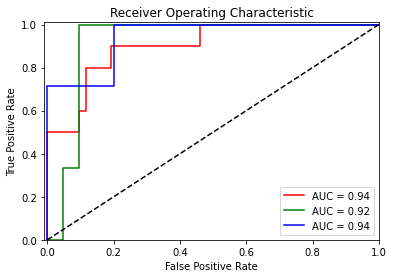

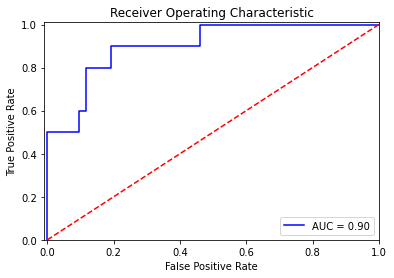

In [149]:

fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
fpr_val, tpr_val, threshold_val = roc_curve(y_val, pred_val)
roc_auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'r', label = 'AUC = %0.2f' % roc_auc_test)
plt.plot(fpr_val, tpr_val, 'g', label = 'AUC = %0.2f' % roc_auc_val)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Save output

In [121]:
X_train.to_csv(os.path.join('../predictions_y', 'X_train.csv'))
np.savetxt(os.path.join('../predictions_y', 'predictions_train.csv'), pred_train, delimiter=";")
np.savetxt(os.path.join('../predictions_y', 'y_train.csv'), y_train, delimiter=";")
X_val.to_csv(os.path.join('../predictions_y', 'X_val.csv'))
np.savetxt(os.path.join('../predictions_y', 'predictions_val.csv'), pred_val, delimiter=";")
np.savetxt(os.path.join('../predictions_y', 'y_val.csv'), y_val, delimiter=";")
X_test.to_csv(os.path.join('../predictions_y', 'X_test.csv'))
np.savetxt(os.path.join('../predictions_y', 'predictions_test.csv'),pred_test, delimiter=";")
np.savetxt(os.path.join('../predictions_y', 'y_test.csv'), y_test, delimiter=";")

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

## TALOS

In [ ]:
import talos as ta

In [ ]:
p = {
    'first_neuron': [512],
    'epochs' :[20, 100],
    'batch_size': [10,15]
}


In [ ]:
t = ta.Scan(x = X_train, y = y_train, x_val = X_val, y_val = y_val, params = p, model = get_model_talos,
            experiment_name ='exp_1', print_params= True)

In [ ]:
###### ENTRENAMIENTO

#history = model.fit(X_train, 
#          y_train,
#          validation_split=0.25,
#          shuffle=True,
#          batch_size=16, 
#          nb_epoch=50,
#          class_weight=class_weight,       
#          verbose=1)

history = model.fit(X_train,y_train,
          validation_data=(X_val, y_val),
          batch_size=batch_size, 
          nb_epoch=epochs,
          class_weight=class_weight_train,
          callbacks = callbacks_list,
          verbose=1)


In [ ]:
save_dir = os.path.join(
    os.getcwd(),
    '../model_results_y'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model.save('../model_results_y/fixed_model.h5')  

## Augmented dataset

In [ ]:
batch_size = 16
epochs = 3
###### ENTRENAMIENTO
out = model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=datagen.flow(X_val, y_val),
                     steps_per_epoch=len(X_train) / batch_size, 
                     epochs=epochs,
                     class_weight=class_weight_train,
                     callbacks = callbacks_list,       
                     verbose=1)

In [ ]:
out.history

In [ ]:
model2.save('../model_results_y/augmented_model.h5')  